In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import PIL
from PIL import Image
import scipy.misc
import random
import pandas as pd
import tensorflow as tf
import h5py
import math


In [2]:
#loading data
# test_bbox = pickle.load( open( "test_bbox.pickle", "rb" ) )
# train_bbox = pickle.load( open( "train_bbox.pickle", "rb" ) )
train_data = pickle.load( open( "train_data.pickle", "rb" ) )
test_data = pickle.load( open( "test_data.pickle", "rb" ) )

In [3]:
#remove images
train_ = filter(lambda x: x[0] != 'nodata', train_data)
test_ = filter(lambda x: x[0] != 'nodata', test_data)

#removing data if digit greater than 5
train_ = filter(lambda x: len(x[1]) < 6, train_)
test_ = filter(lambda x: len(x[1]) < 6, test_)

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app
/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


5


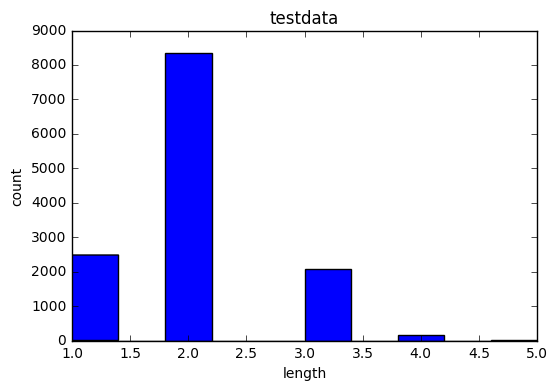

5


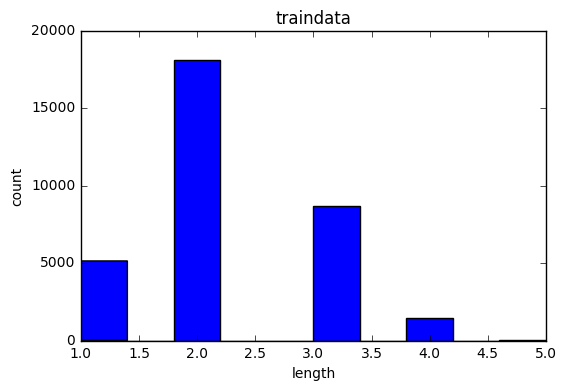

In [4]:
labels = zip(*test_)[1]
labels = [len(i) for i in labels]
print(max(labels))
plt.hist(labels)
plt.xlabel('length')
plt.ylabel('count')
plt.title('testdata')
plt.show()

labels = zip(*train_)[1]
labels = [len(i) for i in labels]
print(max(labels))
plt.hist(labels)
plt.xlabel('length')
plt.ylabel('count')
plt.title('traindata')
plt.show()

In [5]:
# #training on mnist first
train_dataset = np.array(zip(*train_)[0]).astype(dtype=np.float32)
train_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*train_)[1]])

valid_dataset = np.array(zip(*train_)[0]).astype(dtype=np.float32)
valid_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*train_)[1]])

test_dataset = np.array(zip(*test_)[0]).astype(dtype=np.float32)
test_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*test_)[1]])

print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)



image_size = 32
num_labels = 11  #0-9 + blank
num_channels = 1 # grayscale


def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


(33369, 32, 32)
(33369, 6)
(33369, 32, 32)
(33369, 6)
(13058, 32, 32)
(13058, 6)
Training set (33369, 32, 32, 1) (33369, 6)
Validation set (33369, 32, 32, 1) (33369, 6)
Test set (13058, 32, 32, 1) (13058, 6)


In [8]:

#accuracy functions
def accuracy(predictions, labels, batch_size):
    pred = [''.join(np.array(i, dtype = int).astype(str)) for i in predictions]
    lab = [''.join(np.array(i, dtype = int).astype(str)) for i in labels]
    correct = sum([np.array(lab[i]==pred[i]).astype(int) for i in range(len(lab))])/float(batch_size)
    return correct*100.

def accuracy_by_digit(predictions, labels): 
    predictions = np.array(predictions)[:,:5]
    lab = np.array(labels)
    correct_matrix = [(np.array(predictions).T[i] == np.array(lab).T[i]).astype(int) for i in range(len(np.array(predictions).T))]
    percent_correct = [np.mean(i) for i in correct_matrix]
    return percent_correct

# def accuracy_by_digit(predictions, labels): #excludes blanks
#     predictions = np.array(predictions)[:,:5]
#     lab = np.array(labels)
    
#     num_no_10 = [filter(lambda a: a < 10, lab.T[i]) for i in range(5)]
#     num_no_10 = [len(i) for i in num_no_10]
#     lab[lab > 9] = 11

#     correct_matrix = [(np.array(predictions).T[i] == np.array(lab).T[i]).astype(int) for i in range(len(np.array(predictions).T))]
#     percent_correct = [float(sum(correct_matrix[i]))/float(num_no_10[i]+.00001) for i in range(5)]
#     return percent_correct    

#parameters
batch_size = 16
image_size = 32
num_labels = 11
patch_size = 3
test_size = 13058
d1 = 4
d2 = 8
d3 = 16
d4 = 32
d5 = 64
d6 = 128
d7 = 256
d8 = 512
sdev = math.sqrt(2.0 / (32**2*1))


#tensorflow computational graph
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
    tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size,6))
    tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    
    conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
    conv1_b = tf.Variable(tf.zeros([d1]))
    
    conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
    conv2_b = tf.Variable(tf.zeros([d2]))
    
    conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
    conv3_b = tf.Variable(tf.zeros([d3]))
    
    conv4_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d3, d4], stddev=sdev))
    conv4_b = tf.Variable(tf.zeros([d4]))
    
    conv5_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d4, d5], stddev=sdev))
    conv5_b = tf.Variable(tf.zeros([d5]))
    
    conv6_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d5, d6], stddev=sdev))
    conv6_b = tf.Variable(tf.zeros([d6]))
    
    conv7_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d6, d7], stddev=sdev))
    conv7_b = tf.Variable(tf.zeros([d7]))
    
    conv8_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d7, d8], stddev=sdev))
    conv8_b = tf.Variable(tf.zeros([d8]))
    
    
    fc1_w = tf.Variable(tf.truncated_normal([128,512], stddev=0.1))
    fc1_b = tf.Variable(tf.constant(1.0, shape=[64]))
    

    #for final logits
    hidden = 512
    s1_w = tf.get_variable('s1_w', shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s2_w = tf.get_variable('s2_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s3_w = tf.get_variable('s3_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s4_w = tf.get_variable('s4_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s5_w = tf.get_variable('s5_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    
    # Model.
    def model(data):
        '''
        Our best architecture consists of eight convolutional hidden layers
        one locally connected hidden layer, and two densely connected hidden layers.
        All connections are feedforward and go from one layer to the next (no skip connections).
        The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
        while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
        The number of units at each spatial location in each layer is [48, 64, 128, 160] 
        for the first four layers and 192 for all other locally connected layers. 
        The fully connected layers contain 3,072 units each. 
        Each convolutional layer includes max pooling and subtractive normalization. 
        The max pooling window size is 2 × 2. 
        The stride alternates between 2 and 1 at each layer, 
        so that half of the layers don’t reduce the spatial size of the representation. 
        All convolutions use zero padding on the input to preserve representation size. 
        The subtractive normalization operates on 3x3 windows and preserves representation size. 
        All convolution kernels were of size 5 × 5. 
        We trained with dropout applied to all hidden layers but not the input.
        '''
        pad  = 'SAME'
        conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding=pad)
        conv1 = tf.nn.relu(conv1 + conv1_b)
        conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv1.get_shape())
        conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding=pad)
        conv2 = tf.nn.relu(conv2 + conv2_b)
        conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv2.get_shape())
        conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding=pad)
        conv3 = tf.nn.relu(conv3 + conv3_b)
        conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv3.get_shape())
        conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], padding=pad)
        conv4 = tf.nn.relu(conv4 + conv4_b)
        conv4 = tf.nn.max_pool(conv4, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv4.get_shape())
        conv5 = tf.nn.conv2d(conv4, conv5_w, [1, 1, 1, 1], padding=pad)
        conv5 = tf.nn.relu(conv5 + conv5_b)
        conv5 = tf.nn.max_pool(conv5, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv5.get_shape())
        conv6 = tf.nn.conv2d(conv5, conv6_w, [1, 1, 1, 1], padding=pad)
        conv6 = tf.nn.relu(conv6 + conv6_b)
        conv6 = tf.nn.max_pool(conv6, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv6.get_shape())
        conv7 = tf.nn.conv2d(conv6, conv7_w, [1, 1, 1, 1], padding=pad)
        conv7 = tf.nn.relu(conv7 + conv7_b)
        conv7 = tf.nn.max_pool(conv7, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv7.get_shape())
        conv8 = tf.nn.conv2d(conv7, conv8_w, [1, 1, 1, 1], padding=pad)
        conv8 = tf.nn.relu(conv8 + conv8_b)
        conv8 = tf.nn.max_pool(conv8, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv8.get_shape())
    
        shape = conv8.get_shape().as_list()
        reshape = tf.reshape(conv8, [shape[0], shape[1] * shape[2] * shape[3]])
#         print(reshape.get_shape())
#         fc1 = tf.nn.relu(tf.matmul(reshape, fc1_w) + fc1_b)
#         
        fc1 = reshape
        fc1 = tf.nn.dropout(fc1, keep_prob = 0.8)

        #five classifiers for each digit
        s1 = tf.matmul(fc1, s1_w) + s1_b
        s2 = tf.matmul(fc1, s2_w) + s2_b
        s3 = tf.matmul(fc1, s3_w) + s3_b
        s4 = tf.matmul(fc1, s4_w) + s4_b
        s5 = tf.matmul(fc1, s5_w) + s5_b
        
        
        

        return [s1, s2, s3, s4, s5]

 
    # Training computation. #no length logit
    [s1, s2, s3, s4, s5] = model(tf_train_dataset)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s5, tf_train_labels[:,5]))

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(loss) 
    
    # Predictions for the training and evaluation data
    train_prediction = tf.pack([tf.nn.softmax(s1),
                      tf.nn.softmax(s2),
                      tf.nn.softmax(s3),
                      tf.nn.softmax(s4),
                      tf.nn.softmax(s5)])
    
    eval_prediction = tf.pack([tf.nn.softmax(model(tf_eval)[0]),
                             tf.nn.softmax(model(tf_eval)[1]),
                             tf.nn.softmax(model(tf_eval)[2]),
                             tf.nn.softmax(model(tf_eval)[3]),
                             tf.nn.softmax(model(tf_eval)[4])])

    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),
                     tf.nn.softmax(model(tf_test_dataset)[1]),
                     tf.nn.softmax(model(tf_test_dataset)[2]),
                     tf.nn.softmax(model(tf_test_dataset)[3]),
                     tf.nn.softmax(model(tf_test_dataset)[4])])

Initialized
0
Minibatch loss at step 0: 11.991899
Minibatch accuracy at step 0: 0.000000
Minibatch accuracy by digit: [0.06249996093752441, 0.08333326388894677, 0.0, 0.0, 0.0]
Minibatch Predictions
[[10  0 10  3  7 10 10  3  8  3 10  6  8 10  9  5]
 [ 3  2  7  7  6  0  7  3  7  7  7  0  4  3  0  7]
 [ 0  6  0  0  6  0  0  6  0  0  0  6  0  6  0  0]
 [ 8  0  8 10  8  8  8 10  6  8  8  8  8  0 10 10]
 [ 8  8  2  2  7  8  8  8  8  2  8  7  8  8  8  2]]
Minibatch Labels
[[ 7  5  5  7  3  9  1  2  4  6  7  1  8  4  2  2]
 [10  3  6  5  8  7  2 10 10  5  3  0  1 10  5  0]
 [10  0 10 10 10 10  4 10 10 10 10  4 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]
Model saved in file: /Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/STEP2_2_model.ckpt
10000
Minibatch loss at step 10000: 4.441527
Minibatch accuracy at step 10000: 6.250000
Minibatch accuracy by digit: [0.6249996093752441, 0.133333244444

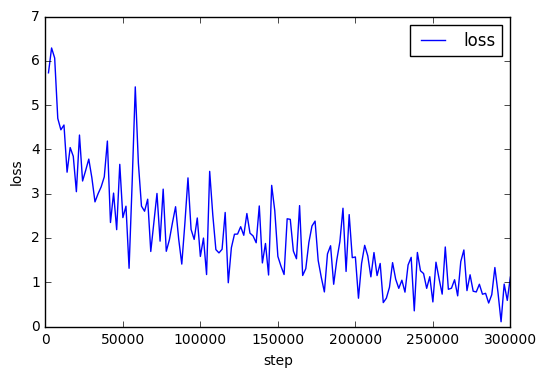

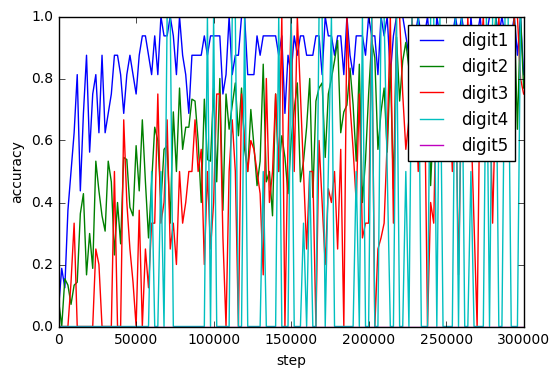

Model saved in file: /Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/STEP2_model.ckpt


In [12]:
num_steps = 300001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    
    step_t = []
    loss_t = []
    acc_t = []
    
    for step in range(num_steps):
        offset = random.randint(0,len(train_dataset)-batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 2000 == 0):
            pred = [list(tf.argmax(predictions[:,i,:],1).eval()) for i in range(batch_size)]
            labels = batch_labels[:,1:]
            step_t.append(step)
            loss_t.append(l)
            acc_t.append(accuracy_by_digit(pred, labels))
        
        if (step % 10000 == 0):
            
            print(step)
            pred = [list(tf.argmax(predictions[:,i,:],1).eval()) for i in range(batch_size)]
            labels = batch_labels[:,1:]
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy at step %d: %f' % (step, accuracy(pred, labels, batch_size)))
            print('Minibatch accuracy by digit:', accuracy_by_digit(pred, labels))

            print('Minibatch Predictions')
            print(np.array(pred).T)
            print('Minibatch Labels')
            print(np.array(labels).T)
            save_path = saver.save(session, os.getcwd() + '/STEP2_2_model.ckpt')
            print("Model saved in file: %s" % save_path)
    
    #figures
    #figures
    plt.figure(1)
    plt.plot(step_t[1:], loss_t[1:], label = 'loss')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()

    plt.figure(2)
    acc_T = np.array(acc_t).T
    acc_T = [list(i) for i in acc_T]
    k = 0
    for i in acc_T:
        k = k + 1
        plt.plot(step_t, i, label = 'digit' + str(k))
    plt.xlabel('step')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    save_path = saver.save(session, os.getcwd() + '/STEP2_model.ckpt')
    print("Model saved in file: %s" % save_path)
#     test_size = 1000
#     pred = [list(tf.argmax(test_prediction[:,i,:],1).eval()) for i in range(test_size)]
#     labels = test_labels[:test_size,1:]
#     print('Test accuracy by digit: ', accuracy_by_digit(pred, labels))

In [12]:
def accuracy_by_digit(predictions, labels): 
    predictions = np.array(predictions)[:,:5]
    lab = np.array(labels)
    correct_matrix = [(np.array(predictions).T[i] == np.array(lab).T[i]).astype(int) for i in range(len(np.array(predictions).T))]
    percent_correct = [np.mean(i) for i in correct_matrix]
    return percent_correct

def accuracy_by_digit(predictions, labels): #excludes blanks
    predictions = np.array(predictions)[:,:5]
    lab = np.array(labels)
    
    num_no_10 = [filter(lambda a: a < 10, lab.T[i]) for i in range(5)]
    num_no_10 = [len(i) for i in num_no_10]
    lab[lab > 9] = 11

    correct_matrix = [(np.array(predictions).T[i] == np.array(lab).T[i]).astype(int) for i in range(len(np.array(predictions).T))]
    percent_correct = [float(sum(correct_matrix[i]))/float(num_no_10[i]+.00001) for i in range(5)]
    return percent_correct   


def predict_with_model(y, model_name, test_size):

    test_dataset = y
    #parameters
    batch_size = 16
    image_size = 32
    num_labels = 11
    patch_size = 3
    d1 = 4
    d2 = 8
    d3 = 16
    d4 = 32
    d5 = 64
    d6 = 128
    d7 = 256
    d8 = 512
    sdev = math.sqrt(2.0 / (32**2*1))


    #tensorflow computational graph
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
        tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size,6))
        tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.

        conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
        conv1_b = tf.Variable(tf.zeros([d1]))

        conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
        conv2_b = tf.Variable(tf.zeros([d2]))

        conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
        conv3_b = tf.Variable(tf.zeros([d3]))

        conv4_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d3, d4], stddev=sdev))
        conv4_b = tf.Variable(tf.zeros([d4]))

        conv5_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d4, d5], stddev=sdev))
        conv5_b = tf.Variable(tf.zeros([d5]))

        conv6_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d5, d6], stddev=sdev))
        conv6_b = tf.Variable(tf.zeros([d6]))

        conv7_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d6, d7], stddev=sdev))
        conv7_b = tf.Variable(tf.zeros([d7]))

        conv8_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d7, d8], stddev=sdev))
        conv8_b = tf.Variable(tf.zeros([d8]))


        fc1_w = tf.Variable(tf.truncated_normal([128,512], stddev=0.1))
        fc1_b = tf.Variable(tf.constant(1.0, shape=[64]))


        #for final logits
        hidden = 512
        s1_w = tf.get_variable('s1_w', shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s2_w = tf.get_variable('s2_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s3_w = tf.get_variable('s3_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s4_w = tf.get_variable('s4_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s5_w = tf.get_variable('s5_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))


        # Model.
        def model(data):
            '''
            Our best architecture consists of eight convolutional hidden layers
            one locally connected hidden layer, and two densely connected hidden layers.
            All connections are feedforward and go from one layer to the next (no skip connections).
            The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
            while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
            The number of units at each spatial location in each layer is [48, 64, 128, 160] 
            for the first four layers and 192 for all other locally connected layers. 
            The fully connected layers contain 3,072 units each. 
            Each convolutional layer includes max pooling and subtractive normalization. 
            The max pooling window size is 2 × 2. 
            The stride alternates between 2 and 1 at each layer, 
            so that half of the layers don’t reduce the spatial size of the representation. 
            All convolutions use zero padding on the input to preserve representation size. 
            The subtractive normalization operates on 3x3 windows and preserves representation size. 
            All convolution kernels were of size 5 × 5. 
            We trained with dropout applied to all hidden layers but not the input.
            '''
            pad  = 'SAME'
            conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding=pad)
            conv1 = tf.nn.relu(conv1 + conv1_b)
            conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv1.get_shape())
            conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding=pad)
            conv2 = tf.nn.relu(conv2 + conv2_b)
            conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv2.get_shape())
            conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding=pad)
            conv3 = tf.nn.relu(conv3 + conv3_b)
            conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv3.get_shape())
            conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], padding=pad)
            conv4 = tf.nn.relu(conv4 + conv4_b)
            conv4 = tf.nn.max_pool(conv4, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv4.get_shape())
            conv5 = tf.nn.conv2d(conv4, conv5_w, [1, 1, 1, 1], padding=pad)
            conv5 = tf.nn.relu(conv5 + conv5_b)
            conv5 = tf.nn.max_pool(conv5, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv5.get_shape())
            conv6 = tf.nn.conv2d(conv5, conv6_w, [1, 1, 1, 1], padding=pad)
            conv6 = tf.nn.relu(conv6 + conv6_b)
            conv6 = tf.nn.max_pool(conv6, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv6.get_shape())
            conv7 = tf.nn.conv2d(conv6, conv7_w, [1, 1, 1, 1], padding=pad)
            conv7 = tf.nn.relu(conv7 + conv7_b)
            conv7 = tf.nn.max_pool(conv7, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv7.get_shape())
            conv8 = tf.nn.conv2d(conv7, conv8_w, [1, 1, 1, 1], padding=pad)
            conv8 = tf.nn.relu(conv8 + conv8_b)
            conv8 = tf.nn.max_pool(conv8, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv8.get_shape())

            shape = conv8.get_shape().as_list()
            reshape = tf.reshape(conv8, [shape[0], shape[1] * shape[2] * shape[3]])
    #         print(reshape.get_shape())
    #         fc1 = tf.nn.relu(tf.matmul(reshape, fc1_w) + fc1_b)
    #         
            fc1 = reshape
            fc1 = tf.nn.dropout(fc1, keep_prob = 0.8)

            #five classifiers for each digit
            s1 = tf.matmul(fc1, s1_w) + s1_b
            s2 = tf.matmul(fc1, s2_w) + s2_b
            s3 = tf.matmul(fc1, s3_w) + s3_b
            s4 = tf.matmul(fc1, s4_w) + s4_b
            s5 = tf.matmul(fc1, s5_w) + s5_b




            return [s1, s2, s3, s4, s5]


        # Training computation. #no length logit
        [s1, s2, s3, s4, s5] = model(tf_train_dataset)

        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s5, tf_train_labels[:,5]))

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(loss) 

        # Predictions for the training and evaluation data
        train_prediction = tf.pack([tf.nn.softmax(s1),
                          tf.nn.softmax(s2),
                          tf.nn.softmax(s3),
                          tf.nn.softmax(s4),
                          tf.nn.softmax(s5)])

        eval_prediction = tf.pack([tf.nn.softmax(model(tf_eval)[0]),
                                 tf.nn.softmax(model(tf_eval)[1]),
                                 tf.nn.softmax(model(tf_eval)[2]),
                                 tf.nn.softmax(model(tf_eval)[3]),
                                 tf.nn.softmax(model(tf_eval)[4])])

        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),
                         tf.nn.softmax(model(tf_test_dataset)[1]),
                         tf.nn.softmax(model(tf_test_dataset)[2]),
                         tf.nn.softmax(model(tf_test_dataset)[3]),
                         tf.nn.softmax(model(tf_test_dataset)[4])])
        
    with tf.Session(graph=graph) as sess:

        sess.run(tf.initialize_all_variables())
        saver.restore(sess, os.getcwd() + model_name)

        pred = [(tf.argmax(test_prediction[:,i,:],1).eval()) for i in range(test_size)]

        return pred

test_size = 500
y = test_dataset[0:test_size]
predictions = predict_with_model(y, '/STEP2_2_model.ckpt', test_size)
d_accur = accuracy_by_digit(predictions, test_labels[:test_size,1:])
k = 1
for i in d_accur:
    print('digit ', k, ': ', i)
    k = k + 1

digit  1 :  0.754
digit  2 :  0.516
digit  3 :  0.804
digit  4 :  0.982
digit  5 :  1.0
